In [1]:
# Libraries
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import cm

In [2]:
class DGM_layer(nn.Module):
    def __init__(self, in_features, out_feature, residual = False):
        super(DGM_layer, self).__init__()
        self.residual = residual
        
        self.Z = nn.Linear(out_feature, out_feature); self.UZ = nn.Linear(in_features, out_feature, bias = False)
        self.G = nn.Linear(out_feature, out_feature); self.UG = nn.Linear(in_features, out_feature, bias = False)
        self.R = nn.Linear(out_feature, out_feature); self.UR = nn.Linear(in_features, out_feature, bias = False)
        self.H = nn.Linear(out_feature, out_feature); self.UH = nn.Linear(in_features, out_feature, bias = False)
        
    def forward(self, x, s):
        z = torch.tanh(self.UZ(x)+self.Z(s))
        g = torch.tanh(self.UG(x)+self.G(s))
        r = torch.tanh(self.UR(x)+self.R(s))
        h = torch.tanh(self.UH(x)+self.H(s))
        return (1-g)*h+z*s        

In [3]:
class DGM_net(nn.Module):
    def __init__(self, in_dim, out_dim, n_layers, n_neurons, residual = False): 
        '''
        in_dim: number of cordinates
        out_dim: number of the output
        make residual = true for identity between each DGM layers 
        '''
        super(DGM_net, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.residual = residual
    
        self.input_layer = nn.Linear(in_dim, n_neurons)
        self.dgm_layers = nn.ModuleList([DGM_layer(self.in_dim, self.n_neurons, 
                                               self.residual) for i in range(self.n_layers)])
        self.output_layer = nn.Linear(n_neurons, out_dim)
    
    def forward(self, x):
        s = torch.tanh(self.input_layer(x))
        for i, dgm_layer in enumerate(self.dgm_layers):
            s = dgm_layer(x, s)
            
        return self.output_layer(s)

In [4]:
class Bellman_pde():
    '''
    Approximating the Bellman PDE on [0,T]*[x1_l,x1_r]*[x2_l,x2_r]
    '''
    def __init__(self, net, x_interval, y_interval, H, M, C, D, R, T, sigma, a):
        self.net = net 
        self.x1_l = x_interval[0].item() # torch tensor, dim = 3
        self.x1_r = x_interval[1].item()
        self.x2_l = y_interval[0].item()
        self.x2_r = y_interval[1].item()
        self.H = H # H, M, C, D, R: torch tensors, dim = 2*2
        self.M = M 
        self.C = C 
        self.D = D 
        self.R = R         
        self.T = T # integer
        self.sigma = sigma # sigma, a: torch tensors, dim = 1*2
        self.a = a 
        
    def sample(self, size):
        # Sampling
        #te  = self.ts[0].item()    
        #x1e = self.ts[1].item()
        #x2e = self.ts[2].item()
        
        t_x = torch.cat((torch.rand([size, 1])*self.T, (self.x1_l - self.x1_r) * torch.rand([size, 1]) + self.x1_r, (self.x2_l - self.x2_r) * torch.rand([size, 1]) + self.x2_r), dim=1)
        # samples = [[t,x1,x2],
        #            [t,x1,x2],
        #               ...
        #            [t,x1,x2]]
        
        x_boundary = torch.cat((torch.ones(size, 1)*self.T, (self.x1_l - self.x1_r) * torch.rand([size, 1]) + self.x1_r, (self.x2_l - self.x2_r) * torch.rand([size, 1]) + self.x2_r), dim=1)
        # samples = [[T,x1,x2],
        #            [T,x1,x2],
        #              ...
        #            [T,x1,x2]]
        
        return t_x, x_boundary
    
    def mat_ext(self, mat, size):
        if mat.shape == torch.Size([2, 2]):
            return mat.unsqueeze(0).repeat(size,1,1)
        elif mat.shape == torch.Size([1, 2]):
            return mat.t().unsqueeze(0).repeat(size,1,1)
        
    def get_hes_space(self, grad_x, x):
        hessian = torch.zeros(len(x),2,2)
        dxx = torch.autograd.grad(grad_x[0][:,1], x, grad_outputs=torch.ones_like(grad_x[0][:,1]), allow_unused=True, retain_graph=True)[0][:,1]
        dxy = torch.autograd.grad(grad_x[0][:,1], x, grad_outputs=torch.ones_like(grad_x[0][:,1]), allow_unused=True, retain_graph=True)[0][:,2]
        dyx = torch.autograd.grad(grad_x[0][:,2], x, grad_outputs=torch.ones_like(grad_x[0][:,2]), allow_unused=True, retain_graph=True)[0][:,1]
        dyy = torch.autograd.grad(grad_x[0][:,2], x, grad_outputs=torch.ones_like(grad_x[0][:,2]), allow_unused=True, retain_graph=True)[0][:,2]
        hessian[:,0,0] = dxx 
        hessian[:,0,1] = dxy
        hessian[:,1,0] = dyx
        hessian[:,1,1] = dyy
        return hessian  
        
        
    def loss_func(self, size):
        
        loss = nn.MSELoss() # MSE 
        
        # Extend the input matrices
        H = self.mat_ext(self.H, size) # H, M, C, D, R: dim = batchsize*2*2
        M = self.mat_ext(self.M, size)
        C = self.mat_ext(self.C, size)
        D = self.mat_ext(self.D, size)
        R = self.mat_ext(self.R, size)
        # a = self.mat_ext(self.a, size) # control: dim = batchsize*2*1           
        T = self.T
        sig = self.sigma.t() # dim = 2*1        
        a = self.a 
            
        x, x_boundary = self.sample(size=size)
        x = x.requires_grad_(True) # Track gradients during automatic differentiation

        # 1st order derivatives
        grad = torch.autograd.grad(self.net(x), x, grad_outputs=torch.ones_like(self.net(x)), create_graph=True)
        
        du_dt = grad[0][:,0].reshape(-1, 1)  # derivative w.r.t. time, dim = batchsize*1
        # du/dt = [[u_t]
        #          [u_t]
        #           ...
        #          [u_t]]  
        
        du_dx = grad[0][:,1:] # derivative w.r.t. space, dim = batchsize*2 
        # du/dx = [[u_x, u_y]
        #          [u_x, u_y]
        #              ...
        #          [u_x, u_y]] 
                
        # Hessian matrix
        #hessian = torch.zeros(size, 2, 2) # dim = batchsize*2*2
        #d2u_dx2 = torch.autograd.grad(du_dx[:, 0], x, grad_outputs=torch.ones_like(du_dx[:, 0]), retain_graph=True)[0][:, 1]
        #d2u_dy2 = torch.autograd.grad(du_dx[:, 1], x, grad_outputs=torch.ones_like(du_dx[:, 1]), retain_graph=True)[0][:, 2]
        #d2u_dxdy = torch.autograd.grad(du_dx[:, 0], x, grad_outputs=torch.ones_like(du_dx[:, 0]), retain_graph=True)[0][:, 2]
        #d2u_dydx = torch.autograd.grad(du_dx[:, 1], x, grad_outputs=torch.ones_like(du_dx[:, 1]), retain_graph=True)[0][:, 1]
        #hessian[:, 0, 0] = d2u_dx2
        #hessian[:, 1, 1] = d2u_dy2
        #hessian[:, 0, 1] = d2u_dxdy
        #hessian[:, 1, 0] = d2u_dydx
        # Hessian = [[[u_xx, u_xy],
        #             [u_yx, u_yy]],
        #            [[u_xx, u_xy],
        #             [u_yx, u_yy]],
        #                  ...     
        #            [[u_xx, u_xy],
        #             [u_yx, u_yy]]] 
        hessian = self.get_hes_space(grad,x)
        
        # Error from the pde
        sig2_ext = self.mat_ext(torch.matmul(sig,sig.t()), size) # dim = batchsize*2*2
        prod = torch.bmm(sig2_ext,hessian) # sigma*sigma^T*2nd derivatives
        trace = torch.diagonal(prod, dim1=1, dim2=2).sum(dim=1).unsqueeze(0).t() # trace, dim = batchsize*1
        x_space = x[:,1:].unsqueeze(1).reshape(size,2,1) # extract (x1,x2)^T, dim = batchsize*2*1
        x_space_t = x_space.reshape(size,1,2) # dim = batchsize*1*2
        du_dx_ext_t = du_dx.unsqueeze(1) # dim=batchsize*1*2
        
        pde = du_dt+0.5*trace+torch.bmm(du_dx_ext_t,torch.bmm(H,x_space)).squeeze(1)\
                +torch.bmm(du_dx_ext_t,torch.bmm(M,a)).squeeze(1)\
                +torch.bmm(x_space_t,torch.bmm(C,x_space)).squeeze(1)\
                +torch.bmm(a.reshape(size,1,2),torch.bmm(D,a)).squeeze(1) # dim = batchsize*1
        
        pde_err = loss(pde, torch.zeros(size,1))
        
        # Error from the boundary condition
        x_bound = x_boundary[:,1:].unsqueeze(1).reshape(size,2,1) # extract (x1,x2)^T, dim = batchsize*2*1
        x_bound_t = x_bound.reshape(size,1,2) # dim = batchsize*1*2
        # boundary = self.net(x_boundary)-torch.bmm(x_bound_t,torch.bmm(R,x_bound)).squeeze(1) # dim = batchsize*1
        
        boundary_err = loss(self.net(x_boundary), torch.bmm(x_bound_t,torch.bmm(R,x_bound)).squeeze(1))
        
        return pde_err + boundary_err

In [5]:
class Train():
    def __init__(self, net, PDE, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = PDE

    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr) # Import the parameters, lr: learning rate
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE)
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step()
            if e % 100 == 99:
                loss = avg_loss/100
                print("epoch {} - lr {} - loss: {}".format(e, lr, loss))
                avg_loss = 0

                error = self.model.loss_func(self.BATCH_SIZE)
                self.errors.append(error.detach())

    def get_errors(self):
        return self.errors

In [6]:
# Initializing the classes
net = DGM_net(in_dim = 3, out_dim = 1, n_layers = 3, n_neurons = 50)
x = torch.tensor([1,4])
y = torch.tensor([1,4])
H = torch.tensor([[1.0,0],[0,1.0]])
M = torch.tensor([[1.0,0],[0,1.0]])
D = torch.tensor([[0.1,0],[0,0.1]])
C = torch.tensor([[0.1,0],[0,0.1]])
R = torch.tensor([[1.0,0],[0,1.0]])
batch_size = 2**10
T = 1
sigma = torch.tensor([[0.05, 0.05]])
#a = torch.tensor([[1.0, 1.0]])
a = torch.randn(batch_size, 2, 1)
Bellman = Bellman_pde(net, x, y, H, M, C, D, R, T, sigma, a)

In [7]:
# Training
train = Train(net, Bellman, BATCH_SIZE=batch_size)
train.train(epoch=10**4, lr=0.0001)
torch.save(net, 'net_model.pkl')
errors = train.get_errors()

epoch 99 - lr 0.0001 - loss: 172.32266693115236
epoch 199 - lr 0.0001 - loss: 59.773974571228024
epoch 299 - lr 0.0001 - loss: 35.69986469268799
epoch 399 - lr 0.0001 - loss: 26.66976276397705
epoch 499 - lr 0.0001 - loss: 19.60836042404175
epoch 599 - lr 0.0001 - loss: 18.104808340072633
epoch 699 - lr 0.0001 - loss: 17.61261930465698
epoch 799 - lr 0.0001 - loss: 17.222434167861937
epoch 899 - lr 0.0001 - loss: 16.958097562789916
epoch 999 - lr 0.0001 - loss: 17.06672016143799
epoch 1099 - lr 0.0001 - loss: 16.813943395614626
epoch 1199 - lr 0.0001 - loss: 16.698250398635864
epoch 1299 - lr 0.0001 - loss: 16.791426954269408
epoch 1399 - lr 0.0001 - loss: 16.515452451705933
epoch 1499 - lr 0.0001 - loss: 16.55095437049866
epoch 1599 - lr 0.0001 - loss: 16.402467126846314
epoch 1699 - lr 0.0001 - loss: 16.609580240249635
epoch 1799 - lr 0.0001 - loss: 16.424943857192993
epoch 1899 - lr 0.0001 - loss: 16.507442026138307
epoch 1999 - lr 0.0001 - loss: 16.523711051940918
epoch 2099 - lr 0

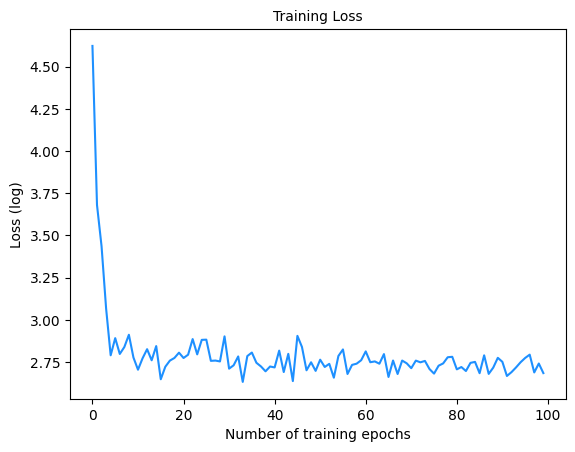

In [17]:
# Plot errors
fig = plt.figure()
plt.plot(np.log10(errors), color = 'dodgerblue', label='Errors')
plt.title('Training Loss', fontsize=10)
plt.xlabel('Number of training epochs')
plt.ylabel('Loss (log)')
plt.show()

In [18]:
net = torch.load('net_model.pkl')
ind = torch.Tensor([[0.5,3,2],[1,1,1]])
Zda = net(ind).detach().cpu().numpy()
print(Zda)

[[18.93732  ]
 [ 4.1964326]]


In [10]:
import scipy.integrate as integrate
import math
def integrand(t):
    res = 1/10*((10*(2**(1/2))+11)*math.exp(2*(2**(1/2))*(1-t))+10*2**(1/2)-11)\
           /((2**(1/2)+9)*math.exp(2*(2**(1/2))*(1-t))+2**(1/2)-9)
    return res
result = integrate.quad(lambda x: integrand(x), 0.5, 1.0)

In [11]:
print(result)

(0.2315651635082677, 1.6141170912431694e-09)


In [12]:
print(integrand(0.5)*(0.5**2+0.8**2)+0.05*result[0])

0.2806147275379891


In [13]:
def value_analytical(x):
    val = torch.zeros(len(x),1)
    for i in range(len(x)):
        val[i] = integrand(x[i,0])*(x[i,1]**2+x[i,2]**2)+0.05*integrate.quad(lambda r: integrand(r), x[i,0].item(), 1.0)[0]
    return val

In [14]:
print(value_analytical(torch.Tensor([[0.5,0.5,0.8],[1,1,1]])))

tensor([[0.2806],
        [2.0000]])
